## Importação Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
database = pd.read_csv('database/airbnb.csv')

In [3]:
duplicated_rows = database.duplicated()
print(duplicated_rows.any())

False


In [4]:
database.columns

Index(['id', 'title', 'description', 'typeDescription', 'roomType',
       'discountedPrice', 'price', 'originalPrice', 'day5Price', 'url',
       'ratingValue', 'ratingReviewsCount', 'ratingGuestSatisfaction',
       'ratingCommunication', 'ratingCleanliness', 'ratingAccuracy',
       'ratingLocation', 'hostID', 'hostName', 'hostAbout', 'hostRating',
       'hostIsSuper', 'hostTimeResponse', 'hostResponseRate', 'latitude',
       'longitude', 'highlights', 'highlightsHost', 'highlightsLocation',
       'origin'],
      dtype='object')

In [5]:
# Remover "R$" e converter colunas de preço para float
def convert_price(value):
    """Remove o símbolo 'R$' e converte para float"""
    return float(value.replace("R$", "").replace(",", "").strip()) if isinstance(value, str) else value

In [6]:
database['discountedPrice'] = database['discountedPrice'].apply(convert_price)
database['price'] = database['price'].apply(convert_price)
database['originalPrice'] = database['originalPrice'].apply(convert_price)
database['day5Price'] = database['day5Price'].apply(convert_price)

In [7]:
# Criar DataFrames filtrando pela coluna 'origin'
db_blm = database[database['origin'] == 'blm']
db_stm = database[database['origin'] == 'stm']

In [8]:
origin_room_type_counts = database.groupby(['origin', 'roomType']).size().unstack(fill_value=0)
print("Quantidade de tipos de hospedagem por origem:")
print(origin_room_type_counts)

Quantidade de tipos de hospedagem por origem:
roomType  Entire home/apt  Private room  Shared room
origin                                              
blm                   277           130            6
stm                   306           141            6


### Separação por Localização (Santarém e Alter do Chão)

In [30]:
from sklearn.cluster import KMeans
import folium
from folium.plugins import MarkerCluster, MiniMap

In [10]:
df_location_stm = db_stm[['id','latitude','longitude']].copy()

In [11]:
# retirar valores nulos
df_location_stm.dropna(axis=0,how='any',subset=['latitude','longitude'],inplace=True)

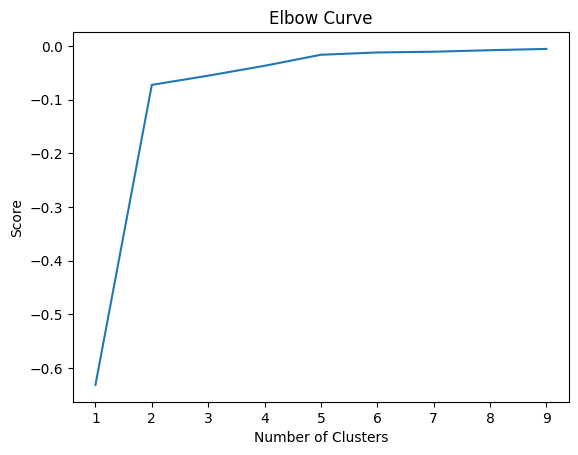

In [12]:
X=df_location_stm.loc[:,['id','latitude','longitude']]

# Elbow Curve
K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df_location_stm[['latitude']]
X_axis = df_location_stm[['longitude']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [13]:
kmeans = KMeans(n_clusters = 2, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
X.head(10)

,id,latitude,longitude,cluster_label
413,1284848925482673940,-2.506643,-54.958631,1
414,1170406999244775557,-2.503780,-54.951200,1
415,1290829230739229679,-2.506362,-54.954638,1
416,763165324786463468,-2.510813,-54.955368,1
417,963094139487772842,-2.503500,-54.958700,1
418,925416981978176829,-2.501740,-54.948860,1
419,977645592663037493,-2.505468,-54.948459,1
420,708138361324411765,-2.505640,-54.957690,1
421,715183140964611968,-2.501770,-54.954950,1
422,40060640,-2.503850,-54.952210,1


In [14]:
loc_type_counts = X['cluster_label'].value_counts()
print("Quantidade por local:")
print(loc_type_counts)

Quantidade por local:
cluster_label
1    312
0    141
Name: count, dtype: int64


In [16]:
# Criar uma cópia do conjunto de dados db_stm
db_stm_copy = db_stm.copy()

# Mapear os valores de cluster_label para 'alter' e 'stm'
cluster_label_map = {1: 'alter', 0: 'stm'}
X['cluster_label_mapped'] = X['cluster_label'].map(cluster_label_map)

# Mesclar db_stm_copy com X para adicionar a nova coluna
db_stm_copy = db_stm_copy.merge(X[['id', 'cluster_label_mapped']], on='id', how='left')

# Renomear a nova coluna para 'location'
db_stm_copy.rename(columns={'cluster_label_mapped': 'location'}, inplace=True)

# Exibir as primeiras linhas do novo DataFrame
db_stm_copy.head()

,id,title,description,typeDescription,roomType,discountedPrice,price,originalPrice,day5Price,url,...,hostIsSuper,hostTimeResponse,hostResponseRate,latitude,longitude,highlights,highlightsHost,highlightsLocation,origin,location
0,1284848925482673940,Flat Paraíso da praia 20324,Relaxe neste espaço calmo e cheio de estilo. A...,"Espaço inteiro: apartamento em Santarém, Brasil",Entire home/apt,NaN,NaN,NaN,1.25,https://www.airbnb.com/rooms/12848489254826739...,...,True,Responde em poucas horas,Taxa de resposta: 100%,-2.506643,-54.958631,"['Comodidades ao ar livre', 'Self check-in', '...","['Meu trabalho: Administradora', 'Moro em: San...","[nan, nan]",stm,alter
1,1170406999244775557,Quarto Muiraquitã •\nCasa AmazôniKaa,Este lugar especial é muito bem localizado pró...,"Quarto em Santarém, Brasil",Private room,235.0,267.0,NaN,1.00,https://www.airbnb.com/rooms/11704069992447755...,...,True,Responde em até 1 hora,Taxa de resposta: 100%,-2.503780,-54.951200,"['Quarto em casa', 'Caminhada de 4 minutos até...","['Meu trabalho: Guia de Turismo', 'Passo muito...","[nan, nan]",stm,alter
2,1290829230739229679,Quarto Triplo 2-Pousada Orquídea,"Localizada no centro de Alter do Chão, a 500 ...","Quarto em Santarém, Brasil",Private room,NaN,NaN,NaN,800.00,https://www.airbnb.com/rooms/12908292307392296...,...,False,Responde em até 1 hora,Taxa de resposta: 100%,-2.506362,-54.954638,"['Quarto em pousada', 'Comodidades ao ar livre...","['Onde estudei: UFMT', 'Meu trabalho: Engenhei...","[nan, nan]",stm,alter
3,763165324786463468,Pousada cardume,Tudo o que você quer explorar está a um passo ...,"Quarto em Santarém, Brasil",Private room,NaN,NaN,NaN,650.00,https://www.airbnb.com/rooms/76316532478646346...,...,True,Responde em até 1 hora,Taxa de resposta: 100%,-2.510813,-54.955368,"['Ótima experiência de check-in', 'Quarto em p...","['Nasci na década de 80', 'Onde estudei: unino...","[nan, nan]",stm,alter
4,963094139487772842,Quarto Tarubá,Em Alter do chão 🏡850 metros da Ilha do Amor e...,"Quarto em Santarém, Brasil",Private room,NaN,NaN,NaN,285.00,https://www.airbnb.com/rooms/96309413948777284...,...,True,Responde em até 1 hora,Taxa de resposta: 99%,-2.503500,-54.958700,"['Quarto em casa', 'Self check-in', 'Cancelame...","['Meu trabalho: airbnb', 'Idiomas: português',...","[nan, nan]",stm,alter


In [25]:
db_only_stm = db_stm_copy[db_stm_copy['location'] == 'stm']
db_only_alter = db_stm_copy[db_stm_copy['location'] == 'alter']

In [26]:
db_only_alter.shape

(312, 31)

In [27]:
db_only_stm.shape

(141, 31)

In [75]:
# Create a map centered around the mean latitude and longitude
map_center_stmalter = [X['latitude'].mean(), X['longitude'].mean()]
map_clusters_stmalter = folium.Map(location=map_center_stmalter, zoom_start=12, tiles='cartodb positron')

# Add points to the map
for idx, row in X.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='green' if row['cluster_label'] == 0 else 'red',
        fill=True,
        fill_color='green' if row['cluster_label'] == 0 else 'red',
        fill_opacity=0.6
    ).add_to(map_clusters_stmalter)

#Add cluster centers to the map
"""
for center in centers:
    folium.Marker(
        location=[center[0], center[1]],
        icon=folium.Icon(color='black')
    ).add_to(map_clusters_stmalter)
"""

# Display the map
map_clusters_stmalter

In [37]:
import json

map_center_lat_stm= db_only_stm['latitude'].mean()
map_center_lon_stm= db_only_stm['longitude'].mean()

map_stm = folium.Map((map_center_lat_stm, map_center_lon_stm), tiles="cartodb positron", control_scale=True,)

geojson_path = "geojson/bairros.geojson"

with open(geojson_path, encoding='utf-8') as f:
    geojson_data = json.load(f)

#Nome dos bairros
folium.GeoJson(
    geojson_data,
    tooltip=folium.GeoJsonTooltip(fields=['name'], aliases=['Bairro:'])
).add_to(map_stm)


#Pontos de hospedagem
marker_cluster_map_stm = MarkerCluster().add_to(map_stm)

# iterrows() -> (indíce, linha)
for i, row in db_only_stm.iterrows():
    try: 
        lat = row['latitude']
        lon = row['longitude']

        # varificação se os valores em lat e lon são números e se são int ou float, caso seja avaliado como invalido irá pular (continue) a coordenada da linha
        if pd.isna(lat) or pd.isna(lon) or not (isinstance(lat, (int,float)) and isinstance(lon, (int, float))): 
            continue

        folium.Marker(
            location=[lat, lon],
            icon=folium.Icon(color='gray')
        ).add_to(marker_cluster_map_stm)

    except (KeyError, TypeError) as e:
        print(f"Erro processando linha de index {i}:{e}")
        continue

map_stm

In [47]:
import geopandas as gpd
from shapely.geometry import Point

# Carregar os dados geojson dos bairros
bairros_gdf = gpd.read_file(geojson_path)

# Definir o CRS do GeoDataFrame dos bairros
bairros_gdf.crs = "EPSG:4674"

# Criar um GeoDataFrame para as hospedagens
geometry = [Point(xy) for xy in zip(db_only_stm['longitude'], db_only_stm['latitude'])]
hospedagens_gdf = gpd.GeoDataFrame(db_only_stm, geometry=geometry, crs="EPSG:4674")

# Realizar a interseção espacial para encontrar o bairro de cada hospedagem
hospedagens_bairros = gpd.sjoin(hospedagens_gdf, bairros_gdf, how="left", predicate='within')

# Contar o número de hospedagens por bairro
quantitativo_hospedagens_bairro = hospedagens_bairros.groupby('name').size().reset_index(name='quantidade')

quantitativo_hospedagens_bairro = quantitativo_hospedagens_bairro.sort_values(by='quantidade', ascending=False)
print(quantitativo_hospedagens_bairro)

                    name  quantidade
22           Santa Clara          12
0        Aeroporto Velho          11
5                 Centro          11
19          Nova Vitória          10
4              Caranazal           8
16              Maracaña           8
9                 Fátima           8
1                 Aldeia           7
20               Prainha           6
10         Interventória           6
14             Liberdade           6
6             Diamantino           5
13              Laguinho           4
11       Jardim Santarém           4
3              Aparecida           4
8               Floresta           3
15                Mapiri           2
2               Alvorada           2
12                 Jutaí           1
17            Maracaña I           1
18                Mararu           1
7              Esperança           1
21  Residencial Salvação           1
23            Santissimo           1
24           Santo André           1
25         São Cristóvão           1
2

In [71]:
import geopandas as gpd
import folium

# Carregar os dados geojson dos bairros
bairros_gdf = gpd.read_file(geojson_path)
bairros_gdf.crs = "EPSG:4674"

# Mesclar os dados de bairros com o quantitativo de hospedagens
bairros_com_quantitativo = bairros_gdf.merge(quantitativo_hospedagens_bairro, left_on='name', right_on='name', how='left')

# Preencher valores nulos com 0 (bairros sem hospedagens)
bairros_com_quantitativo['quantidade'] = bairros_com_quantitativo['quantidade'].fillna(0).astype(int)

# Projetar as geometrias para UTM 21S (EPSG:31981)
bairros_com_quantitativo_projetado = bairros_com_quantitativo.to_crs("EPSG:31981")

# Calcular o centróide com as geometrias projetadas
centroide = bairros_com_quantitativo_projetado.geometry.centroid

# Criar o mapa centralizado no centróide
map_stm_bairros = folium.Map((map_center_lat_stm, map_center_lon_stm), tiles="cartodb positron", control_scale=True, zoom_start=13)

# Adicionar as geometrias dos bairros
folium.GeoJson(
    bairros_com_quantitativo,
    name='Bairros'
).add_to(map_stm_bairros)

# Adicionar a camada choropleth
folium.Choropleth(
    geo_data=bairros_com_quantitativo,
    name='Choropleth',
    data=bairros_com_quantitativo,
    columns=['name', 'quantidade'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Número de Hospedagens',
).add_to(map_stm_bairros)

# Adicionar controle de camadas
folium.LayerControl().add_to(map_stm_bairros)

# Salvar o mapa em um arquivo HTML
#map_stm_bairros.save('mapa_hospedagens_bairros.html')

map_stm_bairros
